In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import statsmodels.api as sm

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import plot_tree

In [2]:
# Read dataset csv file into pandas df
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Data Preprocessing

In [3]:
# No null values in our dataset
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
# Drop identical observations in our dataset
df = df[df.duplicated() != True].reset_index(drop=True)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


Text(0.5, 1.0, 'Box Plot before outlier removing')

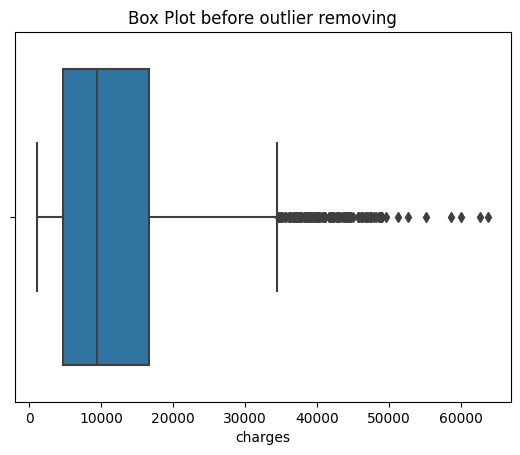

In [5]:
# Visualize distribution of charges
sns.boxplot(x=df['charges'])
plt.title("Box Plot before outlier removing")

### Removing Outliers

In [6]:
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)
iqr = q3 - q1
# Remove observations that are out of range [Q1 - 2.5IQR, Q3 + 2.5IQR]
lower = q1 - 2.5 * iqr
upper = q3 + 2.5 * iqr

print(f'Lower Bound: {lower}, Upper Bound: {upper}')

print(f'Before dropping outliers shape: {df.shape}')

df = df[(df['charges'] > lower) & (df['charges'] < upper)]

print(f'After dropping outliers shape: {df.shape}')

Lower Bound: -25032.089624999997, Upper Bound: 46436.151075
Before dropping outliers shape: (1337, 7)
After dropping outliers shape: (1308, 7)


Text(0.5, 1.0, 'Box Plot after outlier removing')

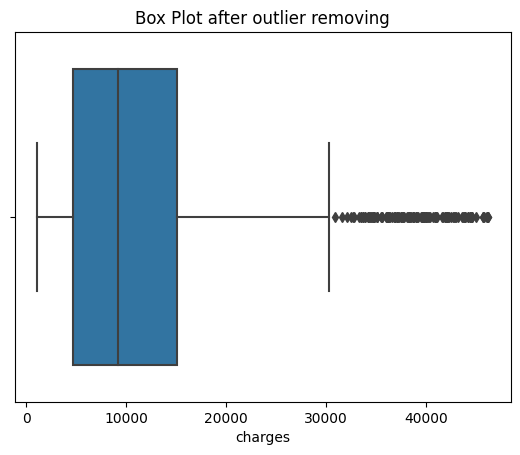

In [7]:
sns.boxplot(x=df['charges'])
plt.title("Box Plot after outlier removing")

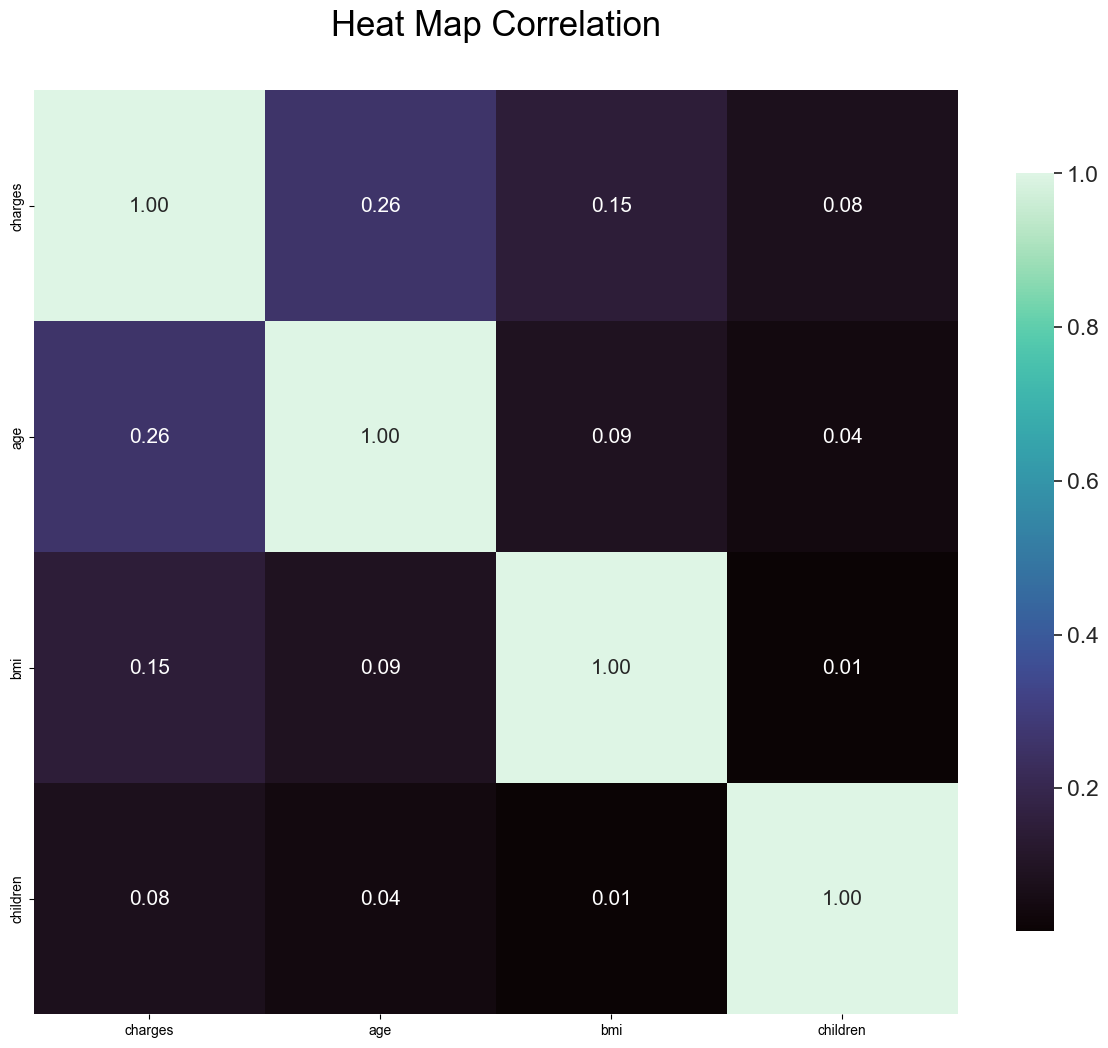

In [8]:
# Generate heatmap to visualize strong & weak correlations.
n_var = 4
matrix = df.corr(numeric_only=True)
cols = matrix.nlargest(n_var, 'charges')['charges'].index
corr_mat = np.corrcoef(df[cols].values.T)

fig, ax = plt.subplots(figsize=(15, 12))

sns.set(font_scale=1.5)
plt.title('Heat Map Correlation', y = 1.05, fontsize = 25)

sns.heatmap(corr_mat, cbar = True, cbar_kws={'shrink': .82}, cmap = 'mako',
                        annot = True, square = True, fmt = '.2f', annot_kws={'size' : 15}, 
                        yticklabels = cols.values, xticklabels = cols.values)
plt.show()

## Feature Engineering

### Map bmi values to bmi_types based on NHS of UK

In [9]:
#-------------------- FEATURE ENGINEERING -------------------------
# Create new column named bmi_types based on column bmi
conditions = [
            (df['bmi'] < 18.5),
            (df['bmi'] >= 18.5) & (df['bmi'] < 25.0),
            (df['bmi'] >= 25.0) & (df['bmi'] < 30.0),
            (df['bmi'] >= 30.0),
]

variables = [
            'underweight',
            'healthy',
            'overweight',
            'obese'
]

df2 = df.copy()
df2['bmi_types'] = np.select(conditions, variables)
df2

,age,sex,bmi,children,smoker,region,charges,bmi_types
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obese
2,28,male,33.000,3,no,southeast,4449.46200,obese
3,33,male,22.705,0,no,northwest,21984.47061,healthy
4,32,male,28.880,0,no,northwest,3866.85520,overweight
...,...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830,obese
1333,18,female,31.920,0,no,northeast,2205.98080,obese
1334,18,female,36.850,0,no,southeast,1629.83350,obese
1335,21,female,25.800,0,no,southwest,2007.94500,overweight


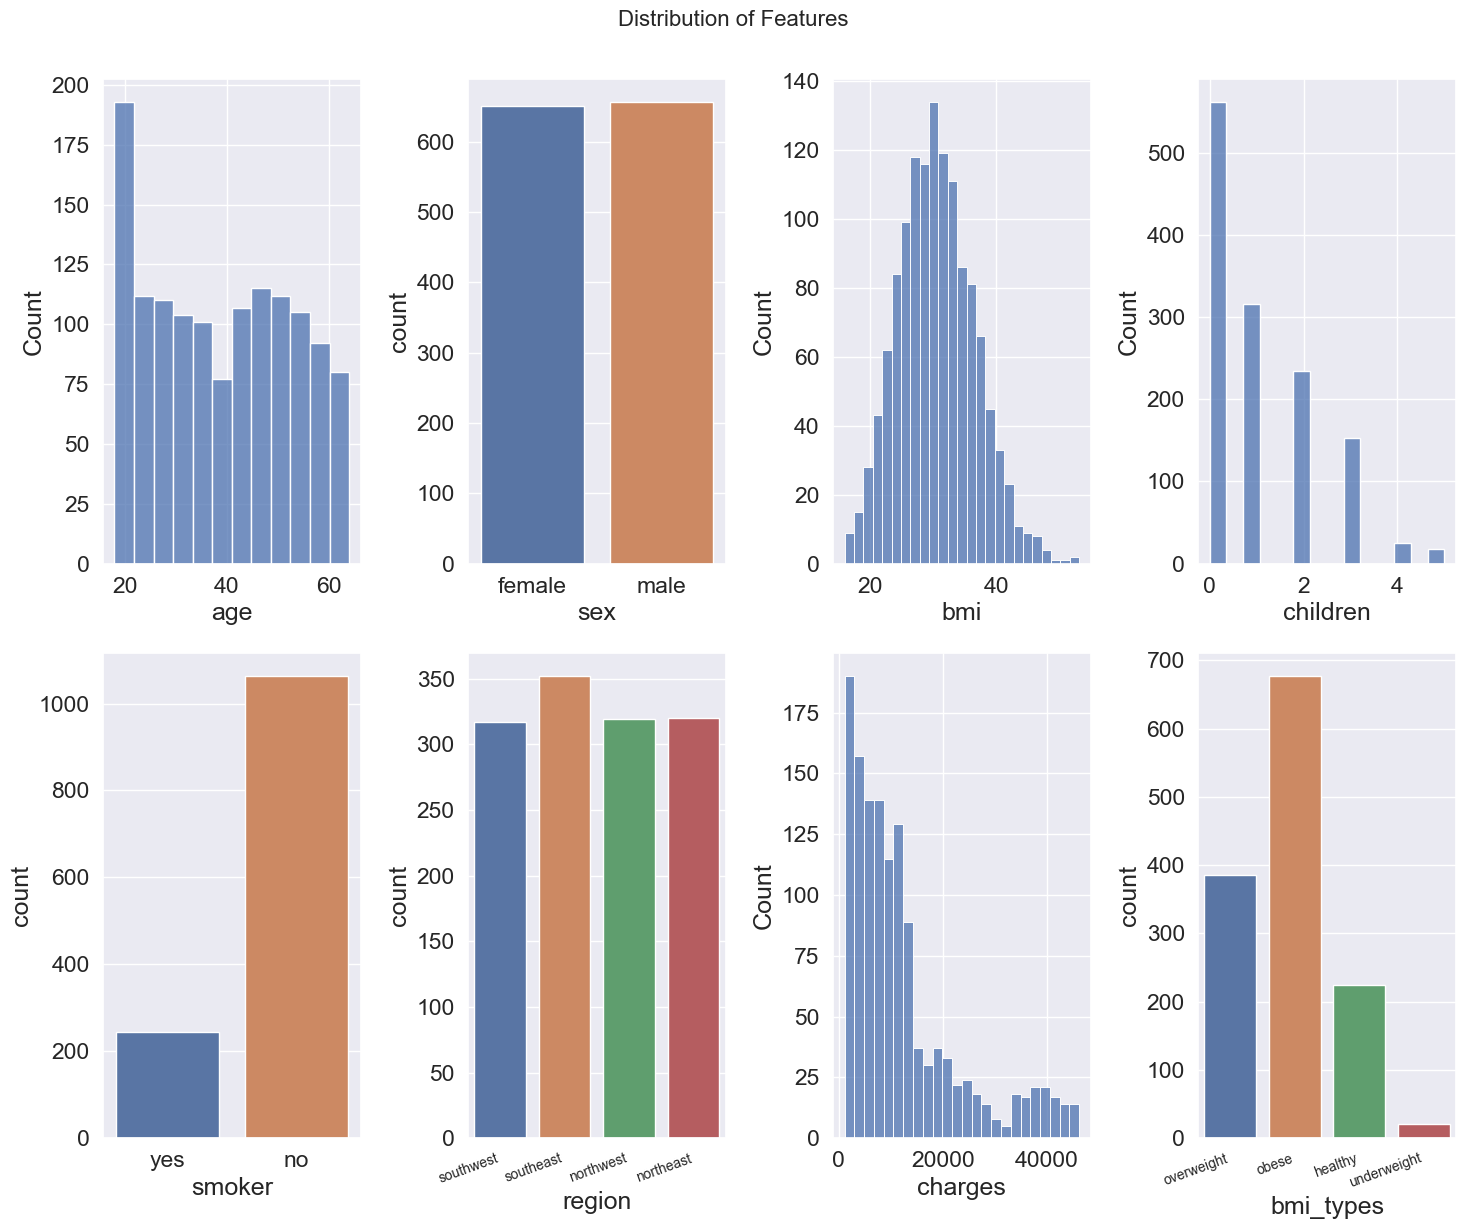

In [10]:
## Plot distributions of the features
# Define the number of rows and columns for figures
n_rows=2
n_cols=4
# Create the subplots
fig, axes = plt.subplots(figsize=(15,12), nrows=n_rows, ncols=n_cols)

for i, column in enumerate(df2.columns):
    if df2[column].dtype == 'object':
        sns.countplot(x=column, data=df2, ax=axes[i//n_cols,i%n_cols])
        if column == "region" or column == "bmi_types":
                plt.sca(axes[i//n_cols,i%n_cols])
                plt.xticks(rotation=20, ha='right', fontsize=10)
    else:
        sns.histplot(df2[column],ax=axes[i//n_cols,i%n_cols])

    plt.tight_layout()

fig.suptitle("Distribution of Features", fontsize=16, y = 1.03)
plt.show()

### Convert categorical features using One-Hot Encoding

In [11]:
df2 = pd.get_dummies(df2, drop_first=True)
df2

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_types_obese,bmi_types_overweight,bmi_types_underweight
0,19,27.900,0,16884.92400,0,1,0,0,1,0,1,0
1,18,33.770,1,1725.55230,1,0,0,1,0,1,0,0
2,28,33.000,3,4449.46200,1,0,0,1,0,1,0,0
3,33,22.705,0,21984.47061,1,0,1,0,0,0,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1332,50,30.970,3,10600.54830,1,0,1,0,0,1,0,0
1333,18,31.920,0,2205.98080,0,0,0,0,0,1,0,0
1334,18,36.850,0,1629.83350,0,0,0,1,0,1,0,0
1335,21,25.800,0,2007.94500,0,0,0,0,1,0,1,0


In [12]:
# Split the dataset into training and test datasets
X, y = df2.drop(columns=['charges'], axis=1), df2['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [13]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [14]:
X_train

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_types_obese,bmi_types_overweight,bmi_types_underweight
0,23,32.780,2,0,1,0,1,0,1,0,0
1,61,35.910,0,0,0,0,0,0,1,0,0
2,49,31.900,5,0,0,0,0,1,1,0,0
3,37,47.600,2,0,1,0,0,1,1,0,0
4,35,43.340,2,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1041,24,29.830,0,1,1,0,0,0,0,1,0
1042,53,26.410,2,1,0,0,0,0,0,1,0
1043,18,36.850,0,0,1,0,1,0,1,0,0
1044,46,19.855,0,1,0,1,0,0,0,0,0


In [15]:
y_train

0       36021.01120
1       13635.63790
2       11552.90400
3       46113.51100
4        5846.91760
           ...     
1041    18648.42170
1042    11244.37690
1043    36149.48350
1044     7526.70645
1045     1136.39940
Name: charges, Length: 1046, dtype: float64

## Data Modelling

In [ ]:
# Define function to calculate performance metrics RMSE and MAE
def print_metrics(y_pred, y):
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)

    # Print the performance metrics
    print("Model Performance Metrics:")
    print("RMSE: ", rmse)
    print("MAE: ", mae)

### Linear Regression Model

In [16]:
# Create Linear Regression Model using statsmodels.api OLS
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

X_train_ols = X_train_ols.rename(columns={'age' : 'age (X1)',	'bmi' : 'bmi (X2)',	'children' : 'children (X3)', 'sex_male' : 'sex_male (X4)',	
                        'smoker_yes' : 'smoker_yes (X5)', 'region_northwest' : 'region_northwest (X6)', 
                        'region_southeast' : 'region_southeast (X7)', 'region_southwest' : 'region_southwest (X8)',
	                    'bmi_types_obese' : 'bmi_types_obese (X9)',	'bmi_types_overweight' : 'bmi_types_overweight (X10)',
                        'bmi_types_underweight' : 'bmi_types_underweight (X11)'})

X_test_ols = X_test_ols.rename(columns={'age' : 'age (X1)',	'bmi' : 'bmi (X2)',	'children' : 'children (X3)', 'sex_male' : 'sex_male (X4)',	
                        'smoker_yes' : 'smoker_yes (X5)', 'region_northwest' : 'region_northwest (X6)', 
                        'region_southeast' : 'region_southeast (X7)', 'region_southwest' : 'region_southwest (X8)',
	                    'bmi_types_obese' : 'bmi_types_obese (X9)',	'bmi_types_overweight' : 'bmi_types_overweight (X10)',
                        'bmi_types_underweight' : 'bmi_types_underweight (X11)'})

In [17]:
# Fit the model and output the summary
lm = sm.OLS(y_train, X_train_ols).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     243.2
Date:                Fri, 31 Mar 2023   Prob (F-statistic):          1.21e-277
Time:                        00:17:05   Log-Likelihood:                -10548.
No. Observations:                1046   AIC:                         2.112e+04
Df Residuals:                    1034   BIC:                         2.118e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

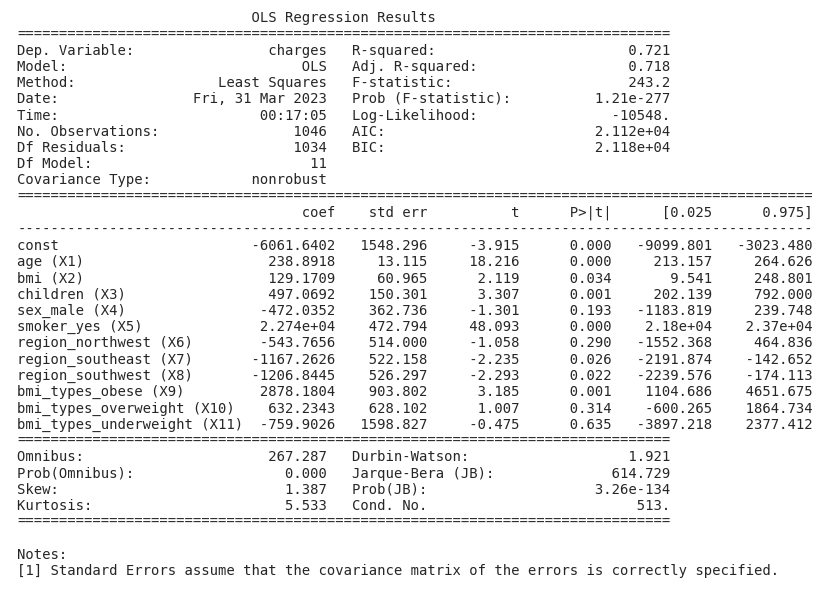

In [18]:
plt.rc('figure', figsize=(9, 7))
plt.text(0.01, 0.05, str(lm.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('lm_output.png')

In [19]:
# Calculate metrics for train and test set
print("Linear Regression Model:\n")
print("Train\n========")
lm_y_pred_train = lm.predict(X_train_ols)
print_metrics(lm_y_pred_train, y_train)
print("R2: ", r2_score(y_train, lm_y_pred_train))

print()
print("Test\n========")
lm_y_pred_test = lm.predict(X_test_ols)
print_metrics(lm_y_pred_test, y_test)

Linear Regression Model:

Train
Model Performance Metrics:
RMSE:  5797.81551750081
MAE:  4053.4543893974055
R2:  0.7211972038844718

Test
Model Performance Metrics:
RMSE:  5135.047109314739
MAE:  3848.359922296413


[Text(0.5, 0, 'Fitted Values'), Text(0, 0.5, 'Residuals')]

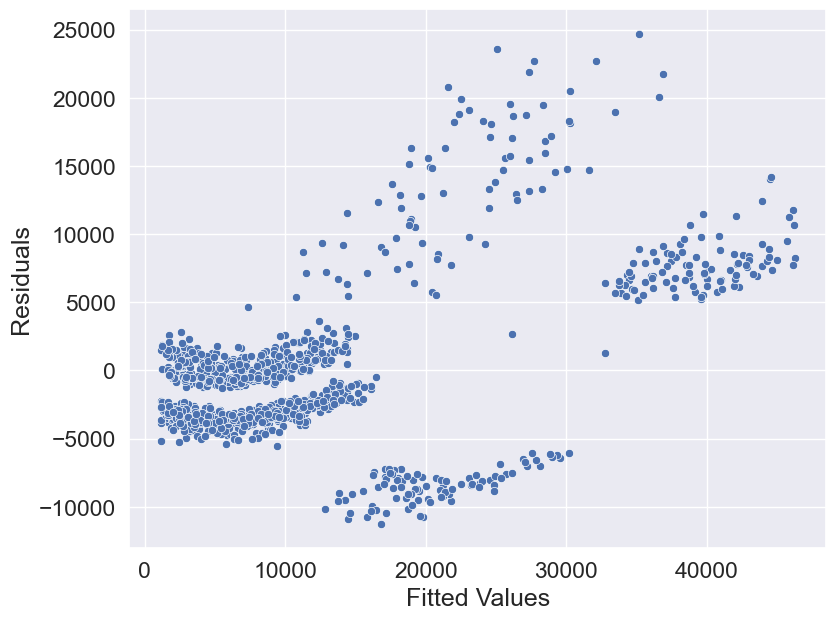

In [20]:
# Create residual scatter plot for Linear Regression Model
residual = y_train - lm_y_pred_train
sns.scatterplot(x=y_train, y=residual).set(xlabel='Fitted Values', ylabel='Residuals')

[Text(0.5, 0, 'Residuals')]

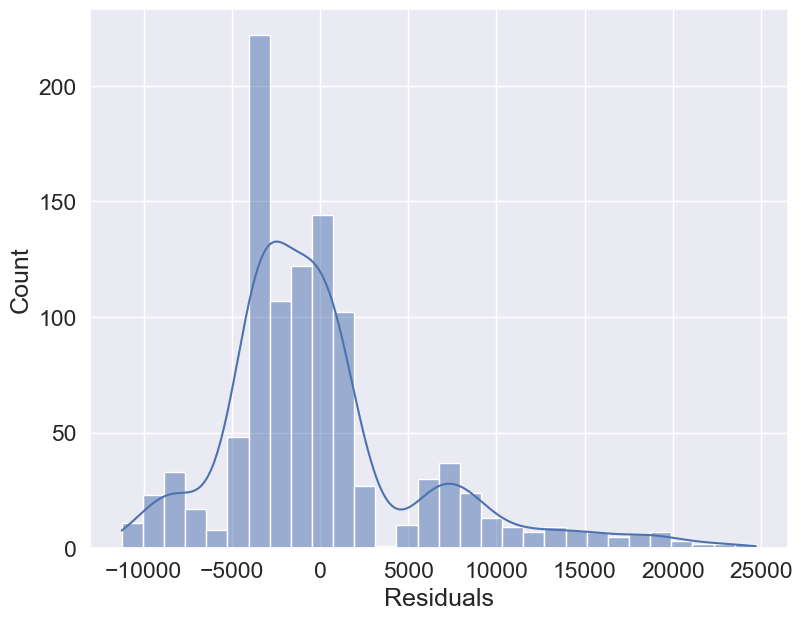

In [21]:
# Create Residual Histogram Plot
sns.histplot(x=residual, bins=30, kde=True).set(xlabel='Residuals')

### Generalized Linear Model (GLM)

[Text(0.5, 0, 'Insurance Charges Distribution')]

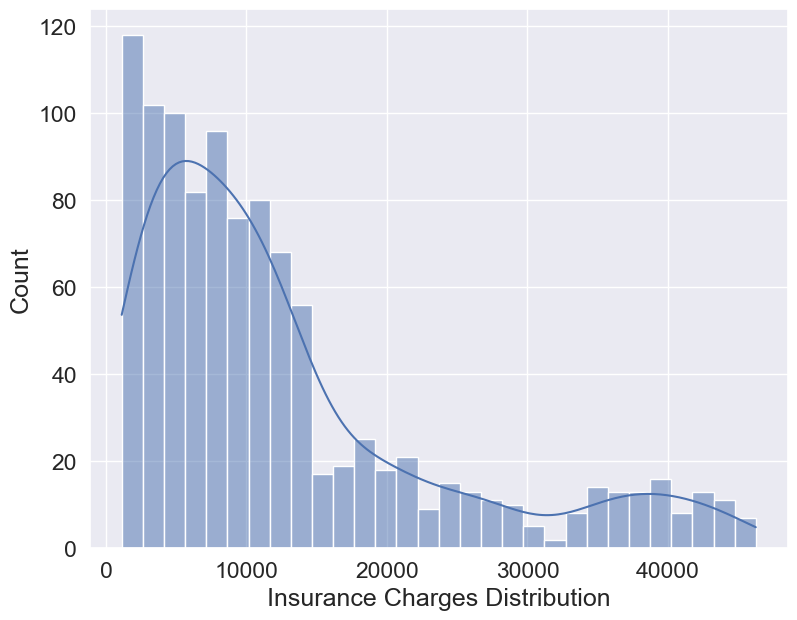

In [22]:
# Charges Distribution Plot
sns.histplot(x=y_train, bins=30, kde=True).set(xlabel='Insurance Charges Distribution')

In [23]:
# GLM with Gamma distribution and log-link
gamma_lm = sm.GLM(y_train, X_train_ols, family=sm.families.Gamma(link=sm.families.links.log())).fit()
print(gamma_lm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                 1046
Model:                            GLM   Df Residuals:                     1034
Model Family:                   Gamma   Df Model:                           11
Link Function:                    log   Scale:                         0.49166
Method:                          IRLS   Log-Likelihood:                -10404.
Date:                Fri, 31 Mar 2023   Deviance:                       277.35
Time:                        00:17:07   Pearson chi2:                     508.
No. Iterations:                    17   Pseudo R-squ. (CS):             0.6150
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

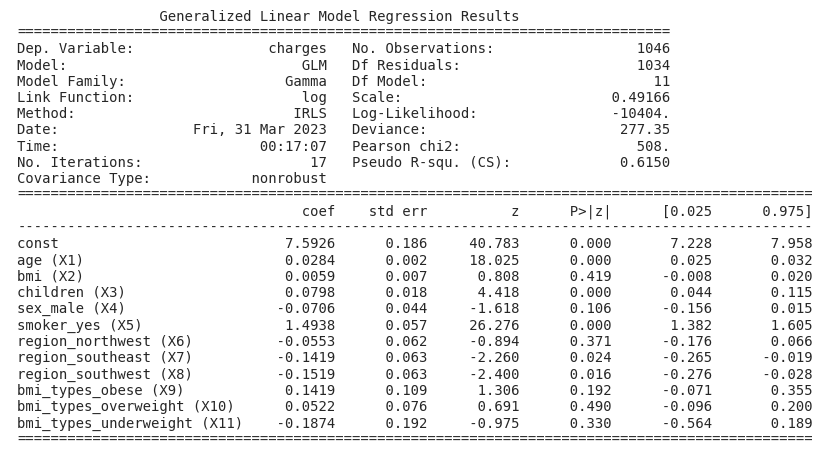

In [24]:
plt.rc('figure', figsize=(9, 5))
plt.text(0.01, 0.05, str(gamma_lm.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('glm_output.png')

In [25]:
print("Generalized Linear Model:\n")
print("Train\n========")
gamma_lm_y_pred_train = gamma_lm.predict(X_train_ols)
print_metrics(gamma_lm_y_pred_train, y_train)
print()
print("Test\n========")
gamma_lm_y_pred_test = gamma_lm.predict(X_test_ols)
print_metrics(gamma_lm_y_pred_test, y_test)

Generalized Linear Model:

Train
Model Performance Metrics:
RMSE:  7368.737471706105
MAE:  4268.882200667784

Test
Model Performance Metrics:
RMSE:  7058.8465770880675
MAE:  3995.5898510947973


### Decision Tree Model

In [27]:
dtr = DecisionTreeRegressor(random_state=15)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=15)

In [28]:
print("Decision Tree Model:\n")
print("Train\n========")
dtr_y_pred_train = dtr.predict(X_train)
print_metrics(dtr_y_pred_train, y_train)
print("R2: ", r2_score(y_train, dtr_y_pred_train))
print("Test\n========")
dtr_y_pred_test = dtr.predict(X_test)
print_metrics(dtr_y_pred_test, y_test)

Decision Tree Model:

Train
Model Performance Metrics:
RMSE:  499.84349672001514
MAE:  30.25104340344168
R2:  0.9979277772730467
Test
Model Performance Metrics:
RMSE:  5489.727466922656
MAE:  2465.196402290076


[Text(0.5, 0.875, 'smoker_yes <= 0.5\nsquared_error = 120567889.717\nsamples = 1046\nvalue = 12572.055'),
 Text(0.25, 0.625, 'age <= 42.5\nsquared_error = 37917011.537\nsamples = 856\nvalue = 8608.567'),
 Text(0.125, 0.375, 'children <= 0.5\nsquared_error = 23312959.604\nsamples = 474\nvalue = 5516.273'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'age <= 51.5\nsquared_error = 29450194.349\nsamples = 382\nvalue = 12445.602'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'bmi <= 30.02\nsquared_error = 103300870.561\nsamples = 190\nvalue = 30428.615'),
 Text(0.625, 0.375, 'age <= 41.0\nsquared_error = 29210766.736\nsamples = 97\nvalue = 21552.177'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'age <= 36.5\nsquared_error = 12683009.589\nsamples = 93\nvalue = 39686.834'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, 

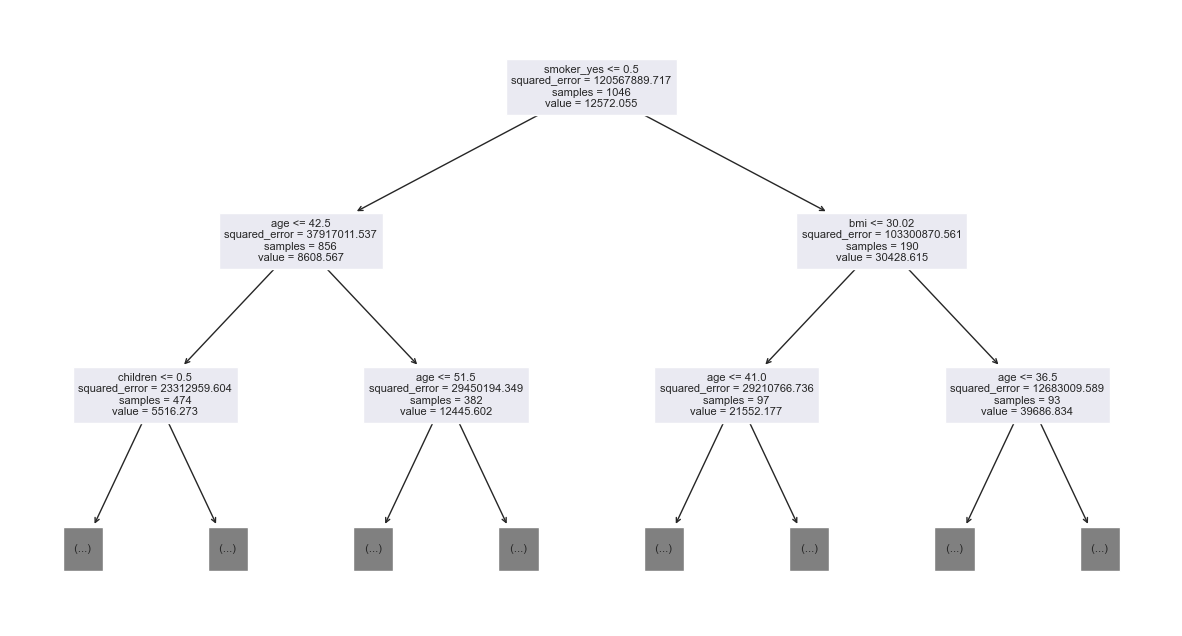

In [29]:
# Visualize tree details
fig = plt.figure(figsize=(15,8))
plot_tree(dtr, max_depth=2, fontsize=8, feature_names=X_train.columns)

### Random Forest Model

In [30]:
rfr = RandomForestRegressor(random_state=15)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=15)

In [31]:
print("Random Forest Model:\n")
print("Train\n========")
rfr_y_pred_train = rfr.predict(X_train)
print_metrics(rfr_y_pred_train, y_train)
print("R2: ", r2_score(y_train, rfr_y_pred_train))
print("Test\n========")
rfr_y_pred_test = rfr.predict(X_test)
print_metrics(rfr_y_pred_test, y_test)

Random Forest Model:

Train
Model Performance Metrics:
RMSE:  1978.0719699577305
MAE:  1128.5726936233966
R2:  0.9675471742310323
Test
Model Performance Metrics:
RMSE:  3636.6443744219923
MAE:  2127.884770386921


### Features Importance

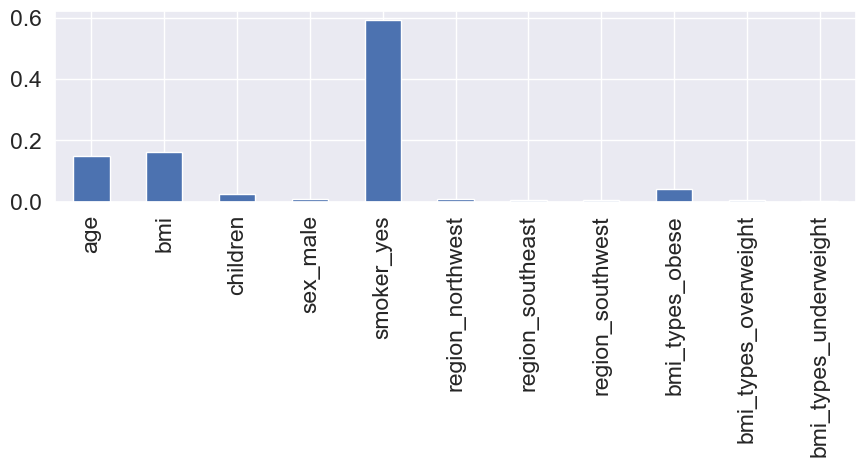

In [33]:
forest_importances = pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
fig.tight_layout()

### Comparison Plot of all models in a y=x plot

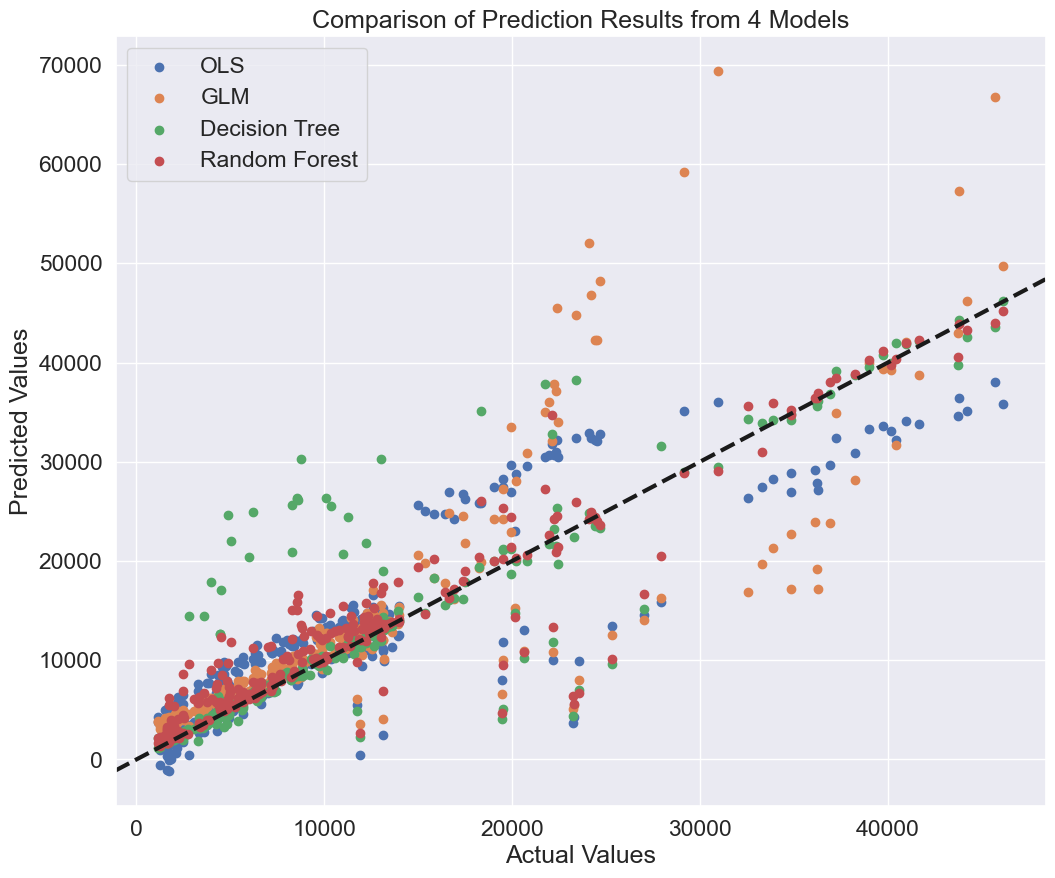

In [34]:
# Create a scatterplot of the predicted values versus the actual values
plt.figure(figsize=(12, 10))
plt.scatter(y_test, lm_y_pred_test, label='OLS')
plt.scatter(y_test, gamma_lm_y_pred_test, label='GLM')
plt.scatter(y_test, dtr_y_pred_test, label='Decision Tree')
plt.scatter(y_test, rfr_y_pred_test, label='Random Forest')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.title("Comparison of Prediction Results from 4 Models")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()